## Merge manual annotations

In this notebook I collect the manual annotations saved in `Pan_fetal_immune/manual_annotation` and add them to the full atlas. In addition I record the assignment of cells to hierarchical splits in the `obs` of the full Pan Fetal Immune atlas.

In [548]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from time import time
from datetime import datetime
import seaborn as sns

In [549]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/collapse_annotation"
if os.path.exists(figdir):
    sc.settings.figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/"
else:
    os.mkdir(figdir)
    sc.settings.figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/"
    

## Load PFI data

In [3]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
PFI_prefix = "PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118"

In [3]:
adata = sc.read_h5ad(data_dir + PFI_prefix + ".h5ad")

In [4]:
## Here I am adding the labels post-hoc
# These will be already saved in the anndata in future iterations
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)
# new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv", index_col=0)
adata.obs = new_obs[new_obs.doublet_scores < 0.4]

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [550]:
cl_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.clustering.obs.csv", index_col=0)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
cl_obs.index = adata.obs_names

In [7]:
adata.obs = pd.concat([adata.obs, cl_obs.loc[adata.obs_names][["leiden_100", "leiden_150"]]],axis=1)

In [8]:
adata

AnnData object with n_obs × n_vars = 897341 × 3195
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'Sample.lanes', 'Sort_id', 'age', 'method', 'sex', 'Processing_method', 'AnnatomicalPart', 'leiden_100', 'leiden_150'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'method_colors', 'neighbors', 'organ_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
adata_obs = adata.obs
adata_var = adata.var

In [ ]:
del adata

### Save info on splits in main anndata
- Which cells belong to which split
- which HVGS where used for each split

In [15]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
keep_splits = ["NKT_CLEAN", "B_CLEAN_CLEAN", "MYELOID_LYMPHOID", "STROMA", "MYELOID","LYMPHOID", "MEM_PROGENITORS"]
s = keep_splits[0]

for s in keep_splits:
    split_file = "{prefix}.{split}.batchCorrected.h5ad".format(prefix = PFI_prefix, split = s)
    if split_file in os.listdir(data_dir):
        s_adata = sc.read_h5ad(data_dir + split_file, backed="r")
    else:
        print("No .h5ad found for split" + s)
    ## Store info on cell assignment to splits 
    adata_obs["isin_split_" + s] = adata_obs.index.isin(s_adata.obs_names)
    ## Store info on hvgs for this split
    adata_var["isHVG_in_split_" + s] = adata_var.index.isin(s_adata.var_names)
    del s_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [23]:
adata_obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.annotated.csv")

In [551]:
adata_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.annotated.csv", index_col=0)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [52]:
### Load manual annotations
anno_dir = '../../manual_annotation/'
keep_anno = ["LYMPHOID"]

adata_obs["anno_lvl_1"] = np.nan
adata_obs["anno_lvl_2"] = np.nan

In [53]:
for anno in keep_anno:
    anno_file = "{prefix}.{anno}.batchCorrected_annotation.csv".format(prefix = PFI_prefix, anno = anno)
    if anno_file in os.listdir(anno_dir):
        anno_df = pd.read_csv(anno_dir + anno_file, index_col=0)
    else:
        print("No .csv found for annotation" + anno)
    ## Check for collisions between annotations (they should have been manually fixed)
    if adata_obs.loc[anno_df.index,'anno_lvl_1'].isna().all():        
        adata_obs.loc[anno_df.index,"anno_lvl_1"] = anno_df["anno_lvl_1"]
        adata_obs.loc[anno_df.index,"anno_lvl_2"] = anno_df["anno_lvl_2"]
    else:
        n_cells=anno_df.index.shape[0] - adata_obs.loc[anno_df.index,'anno_lvl_1'].isna().sum()
        print("Error! {n} cells are already annotated".format(n=n_cells))

## Plot matching of cells to splits

In [552]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [553]:
%%R
library(tidyverse)
library(ggplot2)

In [ ]:
spl_cols = [x for x in adata_obs.columns if "isin" in x]
pl_df = adata_obs[spl_cols]
pl_df["count"] = 1
# pl_df = pl_df.groupby(spl_cols).count().reset_index()
pl_df = pl_df.groupby(spl_cols).sample(frac=0.01)
pl_df[spl_cols] = pl_df[spl_cols].astype("int")
spl_cols = np.array([x for x in adata_obs.columns if "isin" in x])

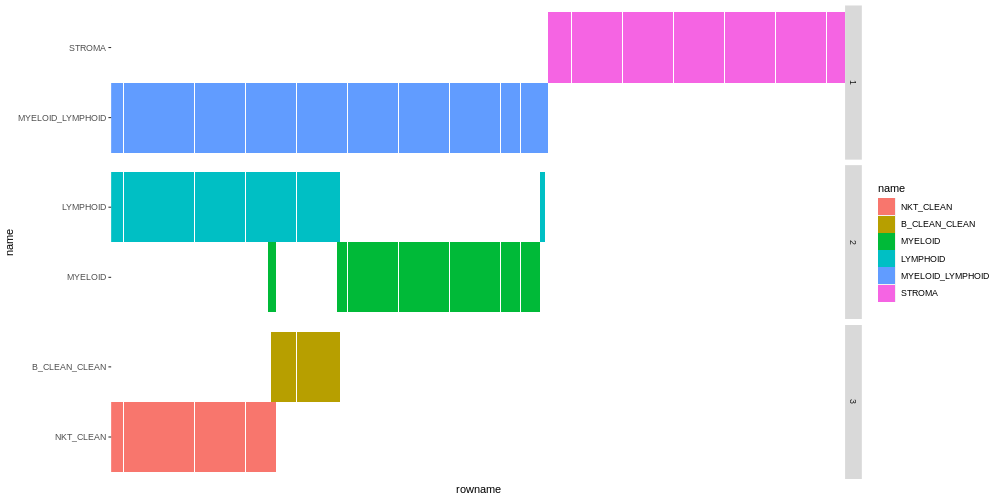

In [555]:
%%R -i pl_df -i spl_cols -w 1000 -h 500
pl_df %>%
rownames_to_column() %>%
pivot_longer(cols=all_of(spl_cols))  %>%
mutate(name=str_remove(name, "isin_split_")) %>%
mutate(spl_level = case_when(name %in% c("STROMA", "MYELOID_LYMPHOID", "MEM_PROGENITORS") ~ 1,
                             name %in% c("MYELOID","LYMPHOID") ~ 2,
                             name %in% c("B_CLEAN_CLEAN","NKT_CLEAN") ~ 3,
                            )) %>%
arrange( - spl_level) %>%
mutate(name=factor(name, levels=unique(name))) %>%
arrange(name) %>%
group_by(name) %>%
# ungroup() %>%
filter(value==1) %>%
mutate(rowname=factor(rowname, unique(rowname))) %>%
ggplot(aes(rowname, name, fill=name)) + 
geom_tile() +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
facet_grid(spl_level~., scales="free", space="free") 
# coord_flip()
# geom_tile(aes(fill=value))

## Old VS new annotation

In [427]:
def make_anno_confusion(anno_df, old_anno="old_anno", new_anno="anno_lvl_2"):
    anno_df["count"] = 1
    conf_df = anno_df.groupby([new_anno, old_anno]).sum().reset_index()
    conf_df.columns = ["new_anno", "old_anno", "count"]
    conf_df = conf_df.pivot(index='old_anno', values="count", columns='new_anno')
    conf_df[conf_df.isna()] = 0
    return(conf_df)

In [244]:
ordered_label = adata_obs[adata_obs["isin_split_" + plot_split]][["uniform_label", "uniform_label_lvl0"]].drop_duplicates().sort_values("uniform_label_lvl0").uniform_label

### New annotation VS uniform annotation 

In [428]:
plot_split = "LYMPHOID"
conf_df = adata_obs[adata_obs["isin_split_" + plot_split]][["anno_lvl_1", "uniform_label"]]
conf_df = make_anno_confusion(conf_df, old_anno="uniform_label", new_anno="anno_lvl_1")

In [248]:
# ordered_label[ordered_label.isin(conf_df.columns)]
label_group = {'CD8aa':"T CELL", 'CMP':"PROGENITOR", 'DN T CELL':'T CELL', 'DP T CELL':'T CELL', 'ELP':'PROGENITOR', 'HSC_MPP':'PROGENITOR', 'ILC':"ILC",
       'MATURE B CELL':'B CELL', 'NK':"T CELL", 'NK T':"T CELL", 'PLASMA B CELL':"B CELL", 'PRE B CELL':"B CELL",
       'PRE PRO B CELL':"B CELL", 'PRO B CELL':"B CELL", 'PRO TO PRE B CELL':"B CELL", 'PROGENITOR':'PROGENITOR',
       'SP T CELL':'T CELL', 'TREG':'T CELL'}

In [249]:
ordered_cols = pd.DataFrame.from_dict([label_group]).T.reset_index().sort_values(0)['index']

In [430]:
conf_frac = conf_df/conf_df.sum(0)
conf_frac = conf_frac[conf_frac.sum(1) > 0.02] ## Remove low cell types
conf_frac = conf_frac[ordered_cols]

anno_tot = conf_df.sum(0)

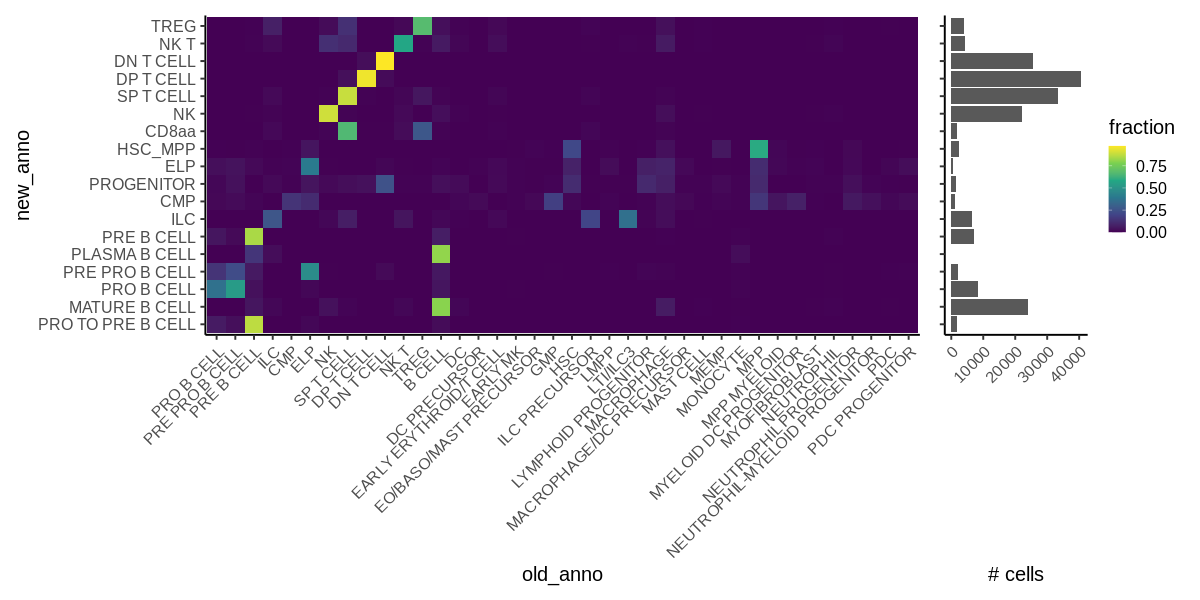

In [431]:
%%R -i conf_frac -i anno_tot -w 1200 -h 600
library(patchwork)

col_order = colnames(conf_frac)
row_order = c(col_order, rownames(conf_frac)[!rownames(conf_frac) %in% col_order])

pl1 <- conf_frac %>%
rownames_to_column("old_anno") %>%
pivot_longer(cols=-old_anno, names_to="new_anno", values_to="fraction") %>%
mutate(old_anno=factor(old_anno, levels=row_order)) %>%
mutate(new_anno=factor(new_anno, levels=col_order)) %>%
ggplot(aes(old_anno, new_anno, fill=fraction)) +
geom_tile() +
scale_fill_viridis_c() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

pl2 <- data.frame(anno_tot) %>%
    rownames_to_column('new_anno') %>%
    mutate(new_anno=factor(new_anno, levels=col_order)) %>%
    ggplot(aes(new_anno, anno_tot)) +
    geom_col() +
#     scale_y_log10() +
    coord_flip() +
    ylab("# cells") +
    theme_classic(base_size=20) +
    theme(axis.text.y=element_blank(), axis.title.y=element_blank(),
         axis.text.x=element_text(angle=45, hjust=1, vjust=1))

pl1 + pl2 +
plot_layout(guides="collect", widths=c(5,1)) 

### New annotation VS detailed annotation for each organ

Not uniform across organs

In [398]:
def _translate_obs_names(x, organ):
    if organ in ["sp", 'bm']:
        if "FCA" in x:
            obs_name = x.split("_")[3]+ '-' +x.split("_")[5]
        else:
            obs_name = x
    elif organ in ["ki"]:
        if "FCA" in x:
            obs_name = x.split("_")[0] + "-" + x.split("_")[-1].split('-')[0]
        else:
            obs_name = x
    elif organ in ["li", 'ys']:
        obs_name = x.split("_")[3]+'-'+x.split("_")[4]
    elif organ in ["sk"]:
        obs_name = x.split("-")[2]+'-'+x.split("-")[0]
    elif organ in ["gu"]:
        obs_name = "-".join(x.split("-")[:2]) + "_" + x.split("-")[2]
    else:
        obs_name = x
    return(obs_name)

In [399]:
annot_dir = '/home/jovyan/mount/gdrive/Pan_fetal/annotations/'
annot_df = pd.read_csv(annot_dir + "uniform_labels_full.csv", index_col=0)
# annot_df.index = annot_df["old_name"]
annot_df.index = ["GEX".join(x.split("prime")) for x in annot_df.index]
new_name = [_translate_obs_names(annot_df.index[i],annot_df.organ[i]) for i in range(annot_df.shape[0])]

In [400]:
annot_df["old_name"] = annot_df.index
annot_df.index = new_name

In [406]:
annot_df.organ = [x.upper() for x in annot_df.organ]

In [516]:
new_annot_df = adata_obs[adata_obs["isin_split_" + plot_split]][["anno_lvl_2","organ"]]
new_annot_df.organ = ["TH" if x=="TH(pharyn)" else x for x in new_annot_df.organ]
conf_dict = {}
tot_dict = {}

for org in new_annot_df.organ.unique():
    new_annot_organ = new_annot_df[new_annot_df.organ==org]
    new_annot_organ = new_annot_organ.loc[new_annot_organ.index.isin(annot_df.index)]
    old_annot = annot_df.loc[new_annot_organ.index]["cell.labels"]
    new_annot_organ["old_anno"] = old_annot
    ## Compute confusion matrix
    conf_df = make_anno_confusion(new_annot_organ)
    conf_frac = conf_df/conf_df.sum(0)
    conf_frac = conf_frac[conf_frac.sum(1) > 0.02] ## Remove low cell types
    anno_tot = pd.DataFrame(conf_df.sum(0), columns=["n_cells"])
    anno_tot["organ"] = org
    conf_frac["organ"] = org
    conf_dict[org] = conf_frac
    tot_dict[org] = anno_tot
    
conf_df = pd.concat(conf_dict.values()).reset_index()
tot_df = pd.concat(tot_dict.values()).reset_index()

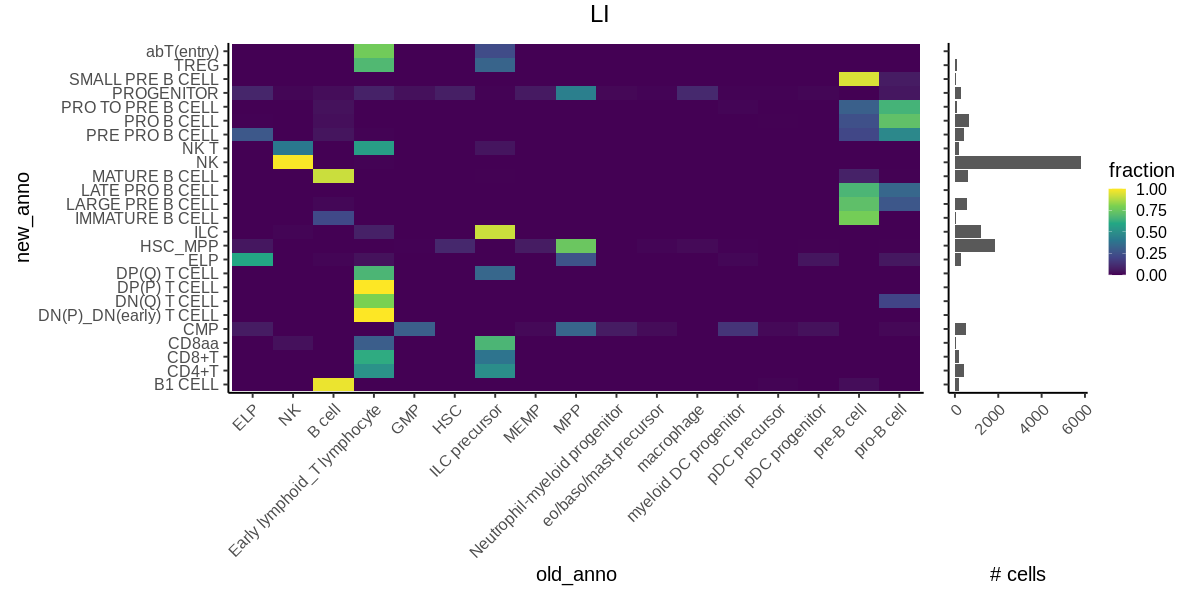

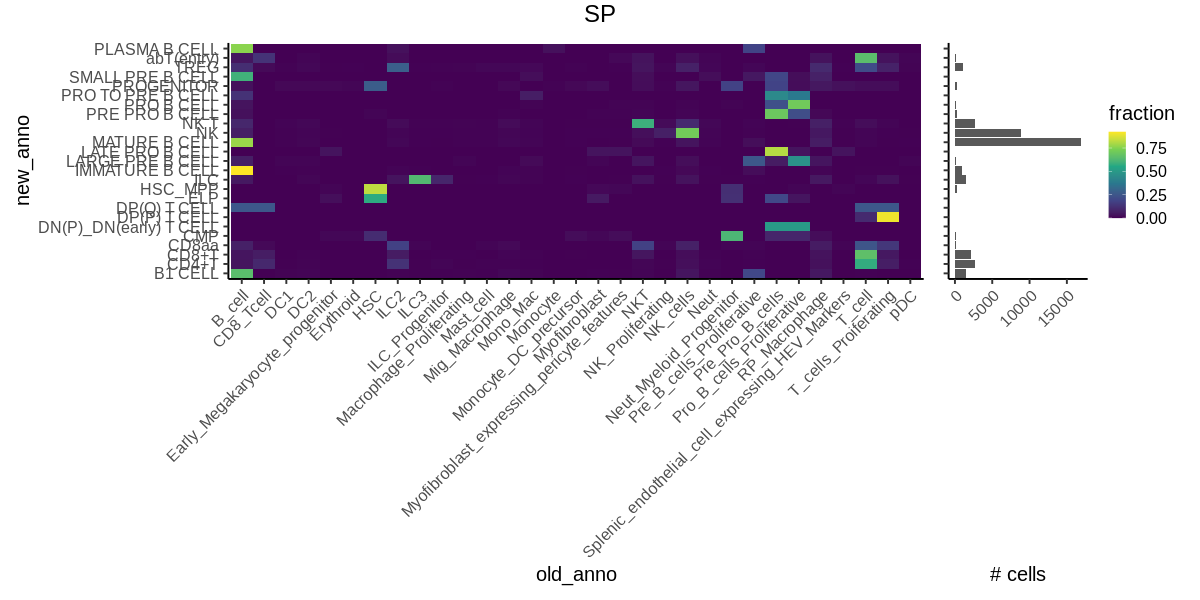

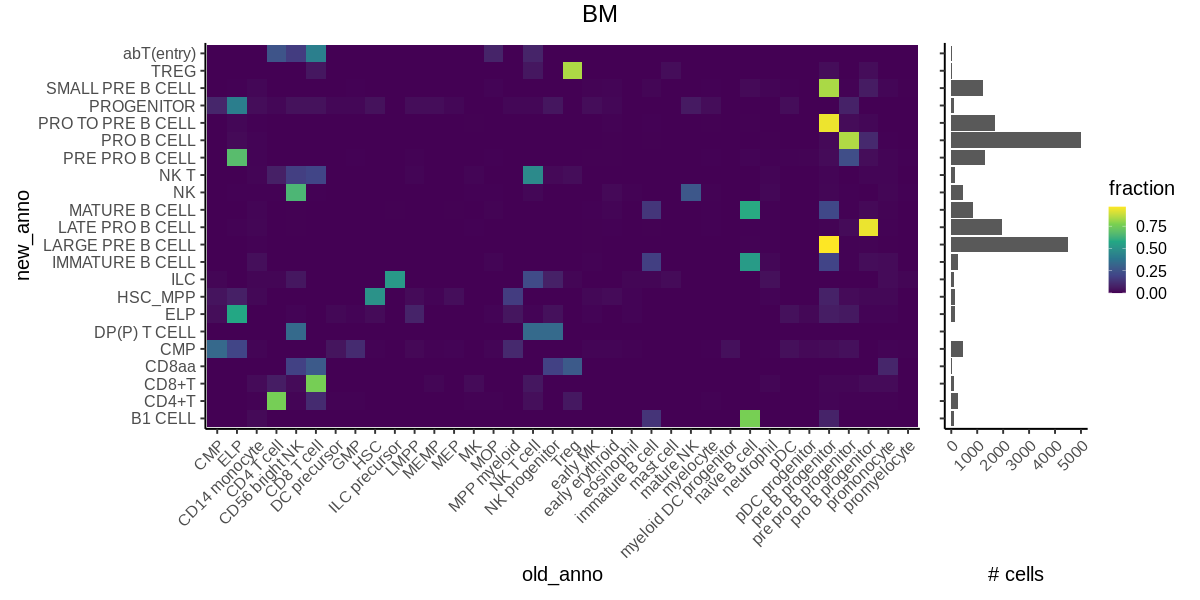

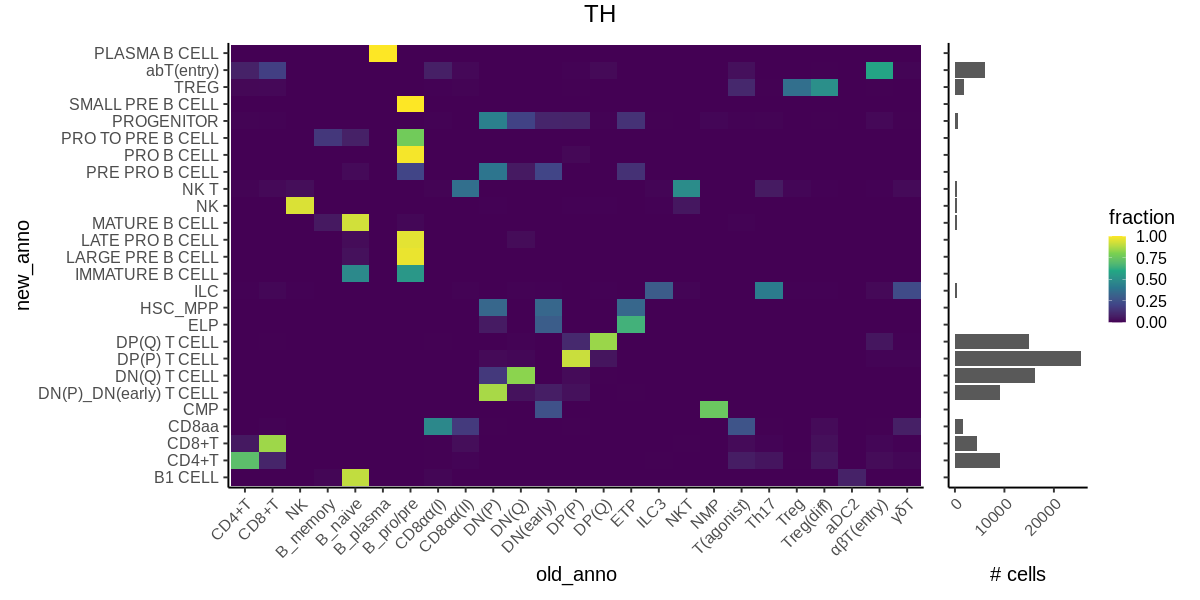

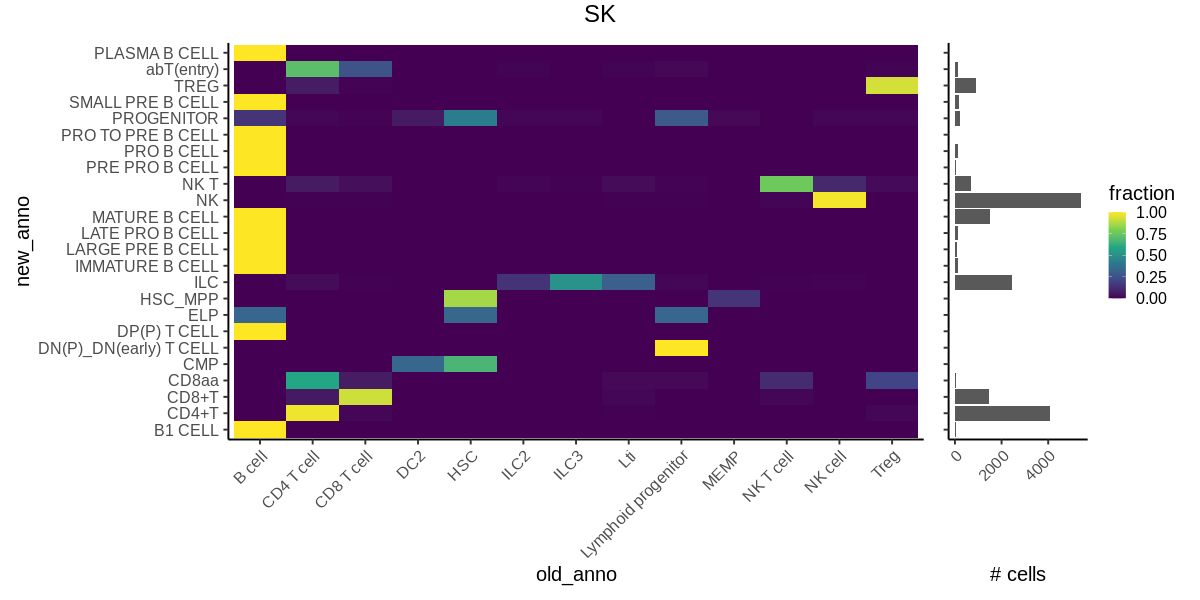

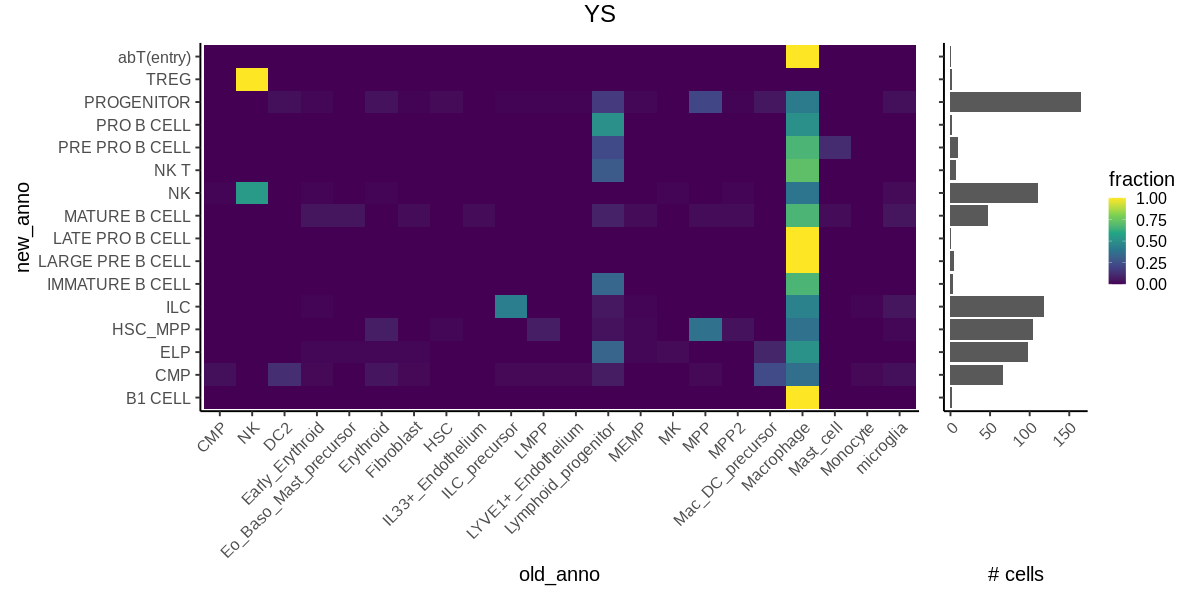

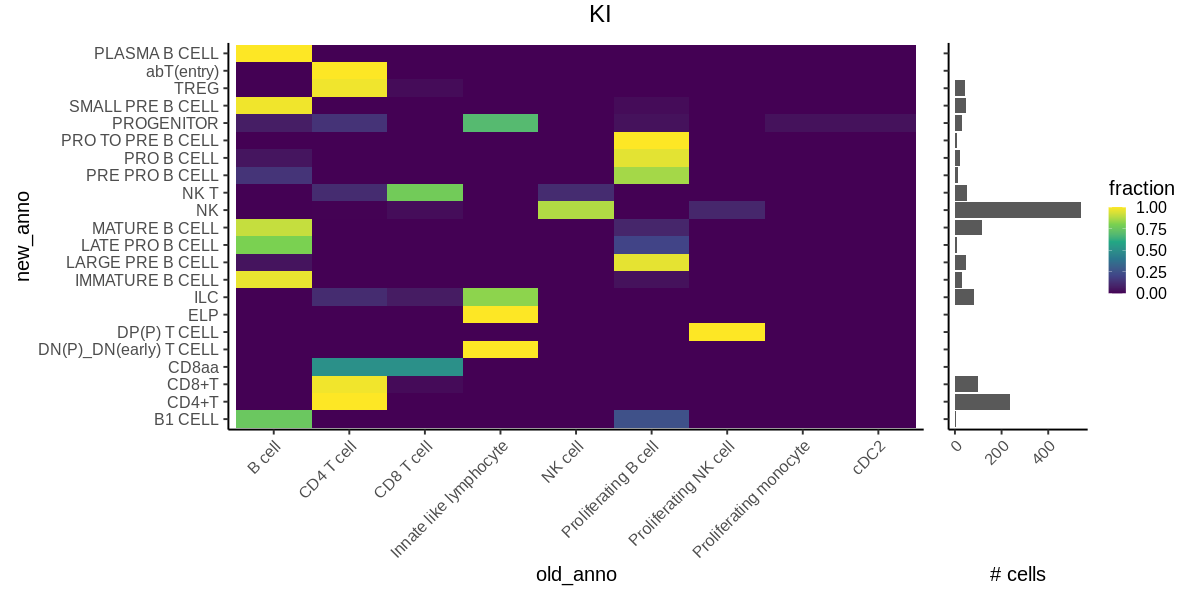

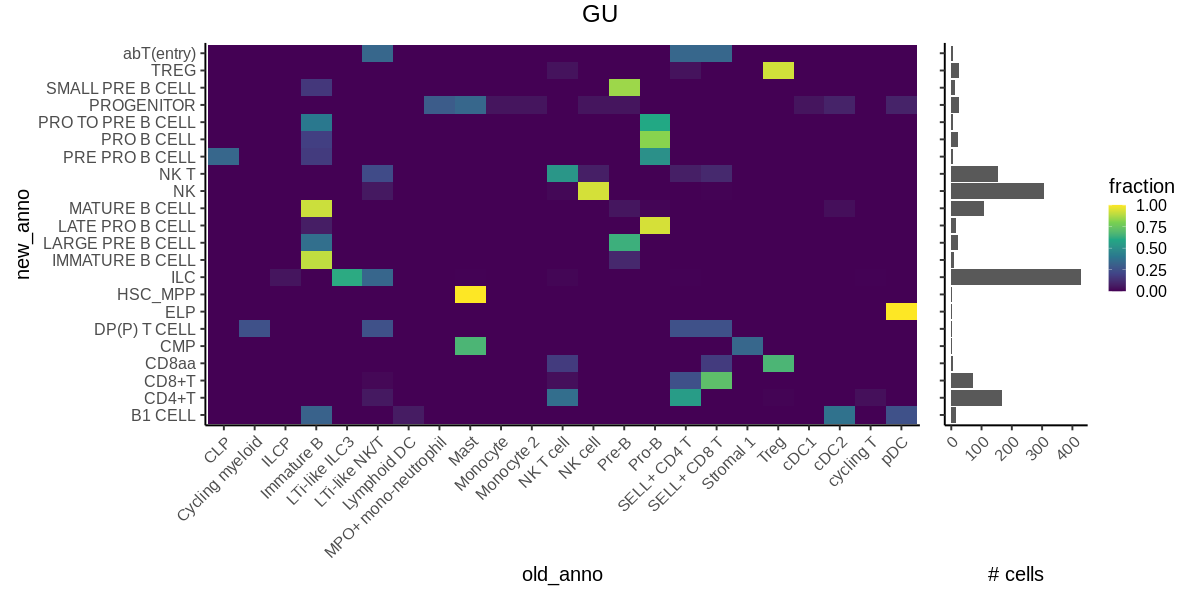

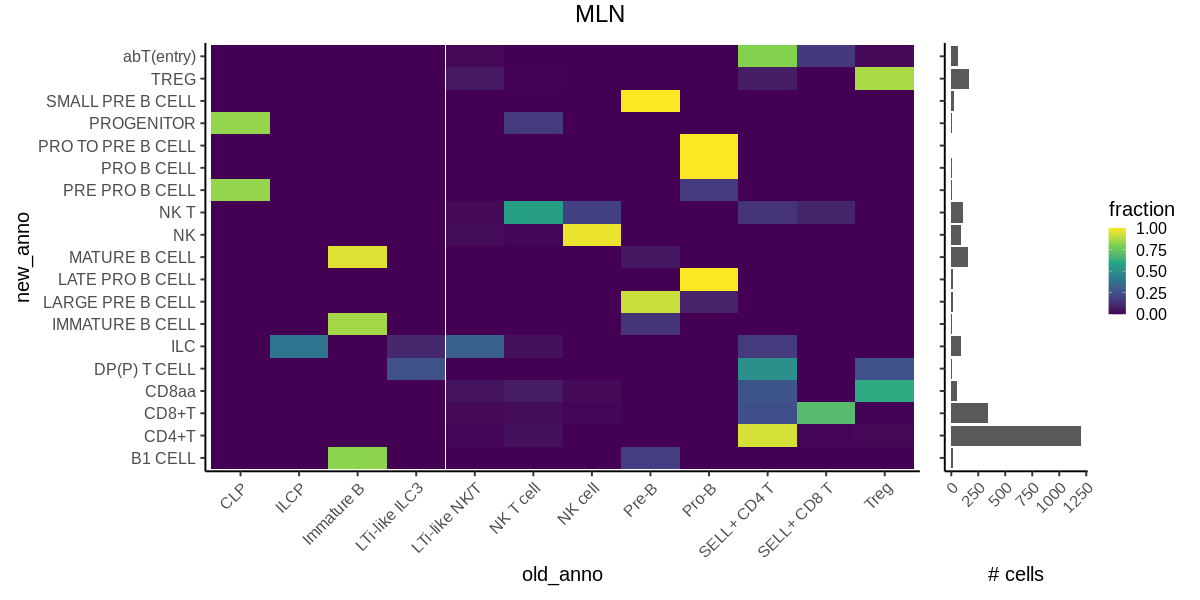

In [547]:
%%R -i conf_df -i tot_df -w 1200 -h 600
library(patchwork)
plot_confusion <- function(conf_frac, anno_tot){
     col_order = colnames(conf_frac)
    row_order = c(col_order, conf_frac$old_anno[!conf_frac$old_anno %in% col_order])

    pl1 <- conf_frac %>%
    pivot_longer(cols=-old_anno, names_to="new_anno", values_to="fraction") %>%
    mutate(old_anno=factor(old_anno, levels=row_order)) %>%
    mutate(new_anno=factor(new_anno, levels=col_order)) %>%
    drop_na() %>%
    ggplot(aes(old_anno, new_anno, fill=fraction)) +
    geom_tile() +
    scale_fill_viridis_c() +
    theme_classic(base_size=20) +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

    pl2 <- data.frame(anno_tot) %>%
        mutate(new_anno=factor(new_anno, levels=col_order)) %>%
        ggplot(aes(new_anno, n_cells)) +
        geom_col() +
    #     scale_y_log10() +
        coord_flip() +
        ylab("# cells") +
        theme_classic(base_size=20) +
        theme(axis.text.y=element_blank(), axis.title.y=element_blank(),
             axis.text.x=element_text(angle=45, hjust=1, vjust=1))

    pl1 + pl2 +
    plot_layout(guides="collect", widths=c(5,1)) 
    }

for (org in unique(conf_df$organ)){
    c_df = conf_df %>%
        filter(organ==org) %>%
        select(- organ)
    t_df = tot_df %>%
        filter(organ==org) %>%
        select(- organ)
    print(plot_confusion(c_df, t_df) + 
         plot_annotation(title = org,
                  theme = theme(plot.title = element_text(size = 24, hjust=0.5))))
}

In [539]:
%%R
    #     %>%
#     ggplot(aes(old_anno, new_anno, fill=fraction)) +
#     geom_tile() +
#     scale_fill_viridis_c() +
#     theme_classic(base_size=20) +
#     theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

      new_anno n_cells
NA        <NA>      NA
NA.1      <NA>      NA
NA.2      <NA>      NA
NA.3      <NA>      NA
NA.4      <NA>      NA
NA.5      <NA>      NA
NA.6      <NA>      NA
NA.7      <NA>      NA
NA.8      <NA>      NA
NA.9      <NA>      NA
NA.10     <NA>      NA
NA.11     <NA>      NA
NA.12     <NA>      NA
NA.13     <NA>      NA
NA.14     <NA>      NA
NA.15     <NA>      NA
NA.16     <NA>      NA
NA.17     <NA>      NA
NA.18     <NA>      NA
NA.19     <NA>      NA
NA.20     <NA>      NA
NA.21     <NA>      NA
NA.22     <NA>      NA
NA.23     <NA>      NA
NA.24     <NA>      NA
NA.25     <NA>      NA
NA.26     <NA>      NA
